# Importing required libraries and dataset #

In [1]:
import pandas as pd
import numpy as np
import datetime
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.model_selection import validation_curve
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.metrics import precision_score
from sklearn.preprocessing import minmax_scale
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


In [2]:
pd.set_option('display.max_rows', 10)

In [3]:
circuits = pd.read_csv('circuits.csv')
con_results = pd.read_csv('constructor_results.csv')
con_standings = pd.read_csv('constructor_standings.csv')
con_teams = pd.read_csv('constructors.csv')
driver_standings = pd.read_csv('driver_standings.csv')
drivers = pd.read_csv('drivers.csv')
lap_times = pd.read_csv('lap_times.csv')
pit_stops = pd.read_csv('pit_stops.csv')
qualifying = pd.read_csv('qualifying.csv')
races = pd.read_csv('races.csv')
results = pd.read_csv('results.csv')
seasons = pd.read_csv('seasons.csv')
status = pd.read_csv('status.csv')

# Exploratory Data Analysis: Analysis of historical data to answer 7Qs through plots and graphs #

## #Q1: Circuit that has recorded most of the crashes: ##

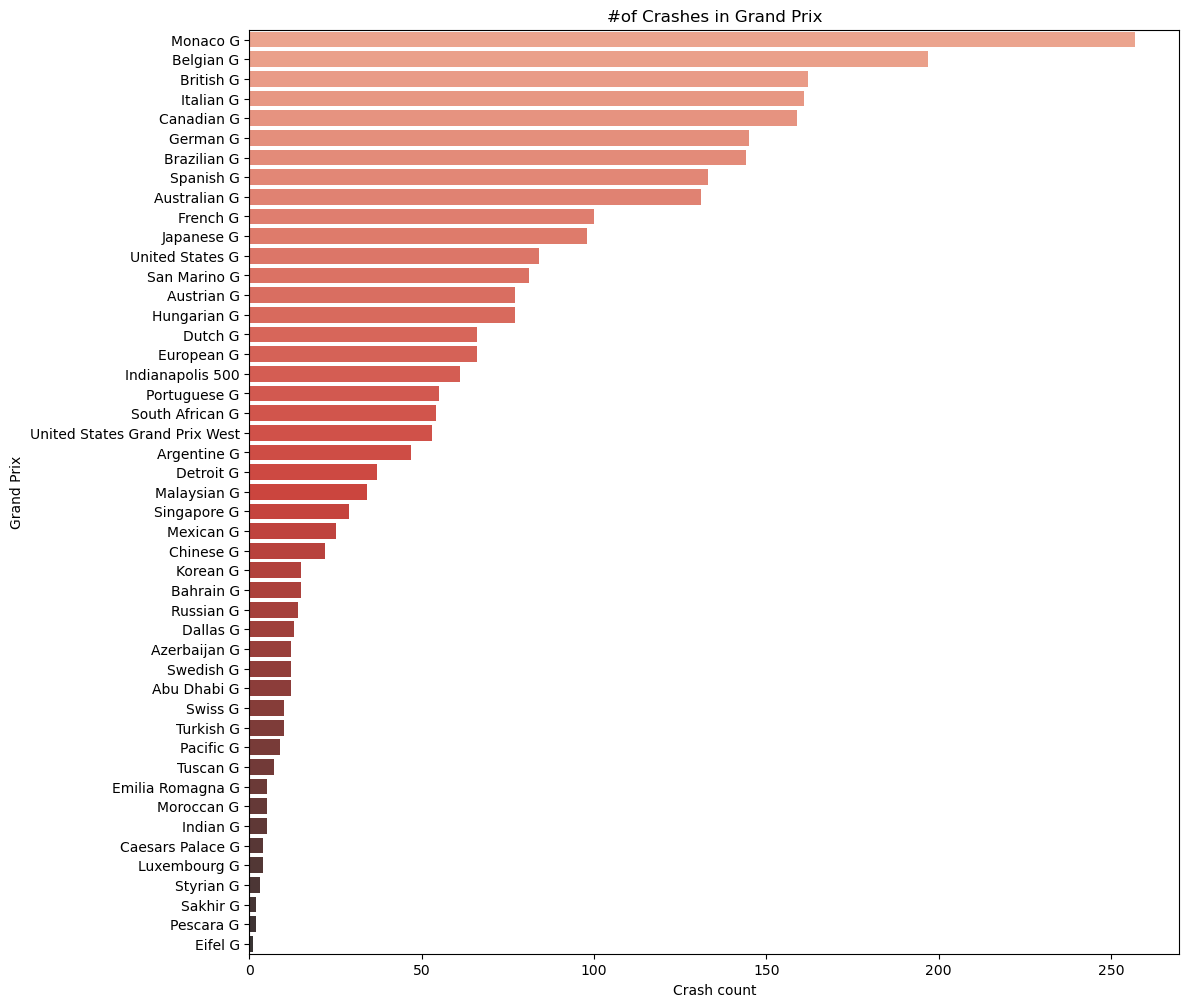

In [4]:
#a1 (raceID) + results (statusId) + races (name)
cir_crash = results[['raceId','driverId','statusId']]
cir_crash = pd.merge(cir_crash, races[['circuitId', 'name','raceId']], on='raceId', how='left')
cir_crash = pd.merge(cir_crash, status[['statusId', 'status']], on='statusId', how='left')

status_options = ['Collision','Collision damage', 'Accident', 'Fatal accident', 'Puncture', 'Type puncture', 'Spun off']
crash = cir_crash[cir_crash['status'].isin(status_options)].reset_index()

cir_crash_count = pd.DataFrame(crash.groupby(['name']).size()).reset_index()
cir_crash_count = cir_crash_count.rename(columns={0:'count'})
cir_crash_count['name'] = cir_crash_count['name'].map(lambda x: x.rstrip('rand Prix'))
cir_crash_count = cir_crash_count.sort_values(by='count', ascending = False)

plt.figure(figsize=(12,12))
sns.barplot(x=cir_crash_count['count'],y=cir_crash_count['name'], palette='Reds_d')
plt.ylabel("Grand Prix")
 
# setting label of x-axis
plt.xlabel("Crash count")
plt.title("#of Crashes in Grand Prix")
matplotlib.rcParams.update({'font.size': 14})
plt.show()

## #Q2: Driver that has recorded most of the crashes: ##

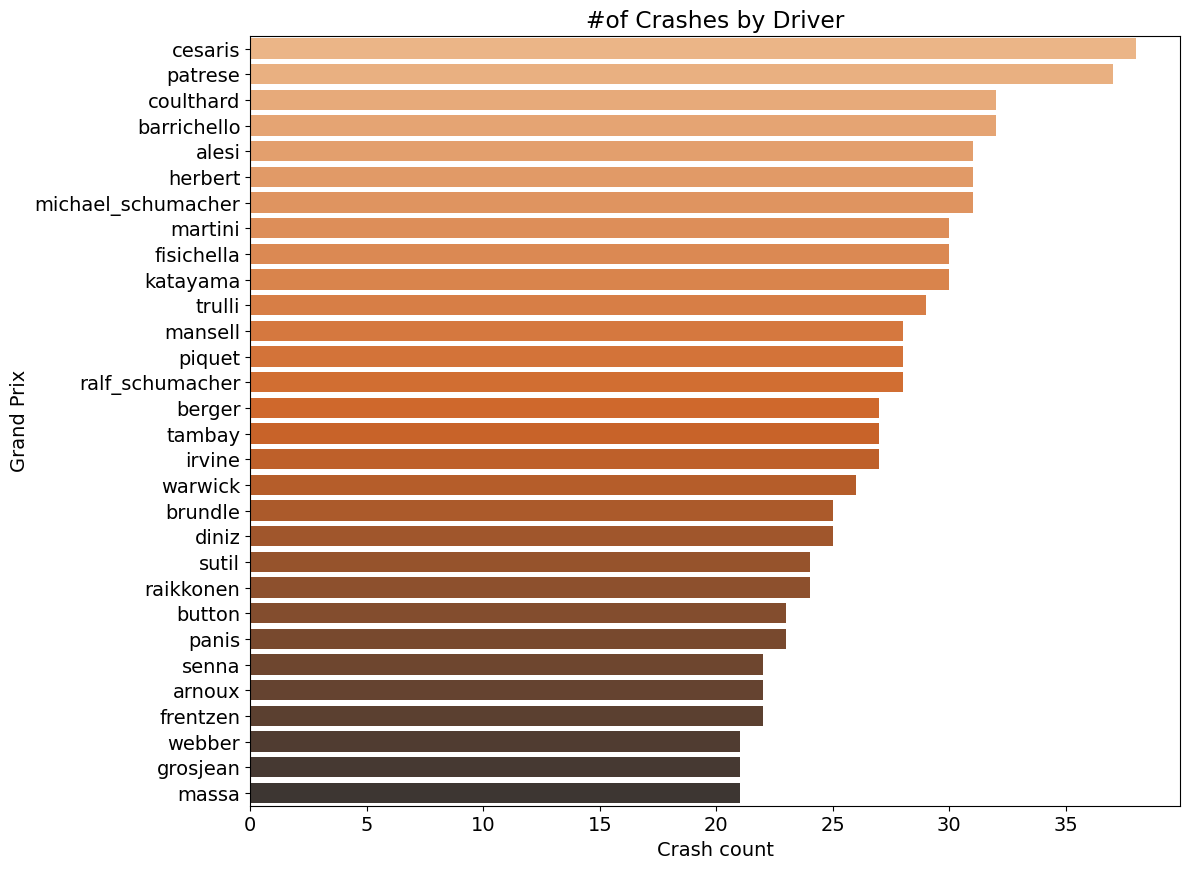

In [5]:
driver_crash = pd.merge(crash, drivers[['driverId', 'driverRef']], on='driverId', how='left')
driver_crash_count = pd.DataFrame(driver_crash.groupby(['driverRef']).size()).reset_index()
driver_crash_count = driver_crash_count.rename(columns={0:'count'})
driver_crash_count = driver_crash_count.sort_values(by='count', ascending = False)
driver_crash_count = driver_crash_count[driver_crash_count['count']>20]

plt.figure(figsize=(12,10))
sns.barplot(x=driver_crash_count['count'],y=driver_crash_count['driverRef'], palette='Oranges_d')
plt.ylabel("Grand Prix")
 
# setting label of x-axis
plt.xlabel("Crash count")
plt.title("#of Crashes by Driver")
matplotlib.rcParams.update({'font.size': 12})
plt.show()

## #Q3 Performance of top 5 drivers since 2015 ##

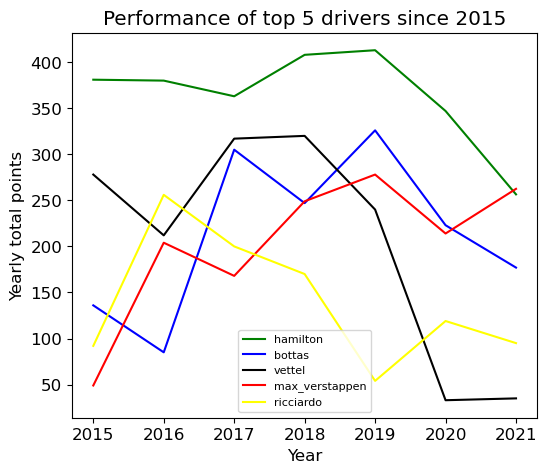

In [6]:
#results (raceID, driverId, points), races(raceId, circuitId), drivers(driverRef)
driv_perf = results[['raceId','driverId','points']]
driv_perf = pd.merge(driv_perf, races[['raceId', 'circuitId','name', 'year']], on='raceId', how='left')
driv_perf = pd.merge(driv_perf, drivers[['driverId', 'driverRef']], on='driverId', how='left')
driv_perf = driv_perf[['name','year','driverRef','points']]
driv_perf = driv_perf[driv_perf['year']>= 2015]
driv_perf = driv_perf[driv_perf['points']!= 0.0]

driv_perf.groupby(['driverRef'])['points'].sum().sort_values(ascending = False)
#top 5 players are hamilton, bottas, vettel, max_verstappen, ricciardo

driver_options = ['hamilton','bottas', 'vettel', 'max_verstappen', 'ricciardo']
t5_driv_perf = driv_perf[driv_perf['driverRef'].isin(driver_options)].reset_index(drop=True)
y_t5_driv_perf = pd.DataFrame(t5_driv_perf.groupby(['driverRef','year'])['points'].sum()).reset_index()
y_t5_driv_perf = pd.pivot_table(y_t5_driv_perf, values='points', index='year', columns='driverRef')
yy_t5_driv_perf = y_t5_driv_perf.reset_index()
yy_t5_driv_perf

#Get current axis
plt.figure(figsize=(6,5))
ax = plt.gca()

# line plot for hamilton
yy_t5_driv_perf.plot(kind = 'line',
        x = 'year',
        y = 'hamilton',
        color = 'green',ax = ax)
# line plot for bottas
yy_t5_driv_perf.plot(kind = 'line',x = 'year',
        y = 'bottas',
        color = 'blue',ax = ax)
# line plot for vettel
yy_t5_driv_perf.plot(kind = 'line',x = 'year',
        y = 'vettel',
        color = 'black',ax = ax)
# line plot for max_verstappen
yy_t5_driv_perf.plot(kind = 'line',x = 'year',
        y = 'max_verstappen',
        color = 'red',ax = ax)
# line plot for ricciardo
yy_t5_driv_perf.plot(kind = 'line',x = 'year',
        y = 'ricciardo',
        color = 'yellow',ax = ax)
# set the title
plt.title('Performance of top 5 drivers since 2015')
plt.ylabel("Yearly total points")
plt.xlabel("Year")
plt.legend(prop={"size":8})
# show the plot
plt.show()

## #Q4 Performance of top 4 teams since 2015 ##

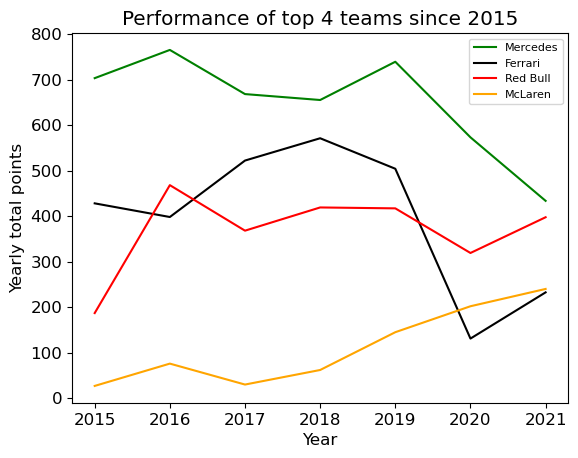

In [7]:
#con_results (raceID, contructorId, points), races(raceId, circuitId, name, year)
con_perf = con_results[['raceId','constructorId','points']]
con_perf = pd.merge(con_perf, races[['raceId', 'circuitId','name', 'year']], on='raceId', how='left')
con_perf = pd.merge(con_perf, con_teams[['constructorId', 'name']], on='constructorId', how='left')
con_perf = con_perf.rename(columns={"name_x":"grand_prix", "name_y":"con_team"})
con_perf = con_perf[['grand_prix','year','con_team','points']]
con_perf = con_perf[con_perf['year']>= 2015]
con_perf = con_perf[con_perf['points']!= 0.0]

con_perf.groupby(['con_team'])['points'].sum().sort_values(ascending = False)
#top 4 teams are Mercedes, Ferrari, Redbull, and McLaren

con_team_options = ['Mercedes','Ferrari', 'Red Bull', 'McLaren']
t4_team_perf = con_perf[con_perf['con_team'].isin(con_team_options)].reset_index(drop=True)
y_t4_team_perf = pd.DataFrame(t4_team_perf.groupby(['con_team','year'])['points'].sum()).reset_index()
y_t4_team_perf = pd.pivot_table(y_t4_team_perf, values='points', index='year', columns='con_team')
yy_t4_team_perf= y_t4_team_perf.reset_index()
yy_t4_team_perf

#Get current axis
ax = plt.gca() 
# line plot for Mercedes
yy_t4_team_perf.plot(kind = 'line',
        x = 'year',
        y = 'Mercedes',
        color = 'green',ax = ax)
# line plot for Ferrari
yy_t4_team_perf.plot(kind = 'line',x = 'year',
        y = 'Ferrari',
        color = 'black',ax = ax)
# line plot for Red Bull
yy_t4_team_perf.plot(kind = 'line',x = 'year',
        y = 'Red Bull',
        color = 'red',ax = ax)
# line plot for McLaren
yy_t4_team_perf.plot(kind = 'line',x = 'year',
        y = 'McLaren',
        color = 'orange',ax = ax)

# set the title
plt.title('Performance of top 4 teams since 2015')
plt.ylabel("Yearly total points")
plt.xlabel("Year")
plt.legend(prop={"size":8})
# show the plot
plt.show()

In [8]:
#merging results with races df
df1 = results.merge(races, how="inner", on='raceId')
#removing time of the races (not important)
df1 = df1.drop('time_y', axis=1)

#merging df1 with drivers df
df2 = df1.merge(drivers, how='inner', on='driverId')
#dropping both url columns (not important)
df2 = df2.drop(['url_x', 'url_y'], axis=1)
#renaming column names for better understanding
df2 = df2.rename(columns={'number_x':'resultsdf_number', 'time_x': 'resultsdf_time', 'number_y':'driver_number', 'date':'date_of_race', 'points':'resultsdf_points'})
#converting date of race to datetime format
df2['date_of_race'] = pd.to_datetime(df2['date_of_race'], format='%Y-%m-%d')
#converting date of birth to datetime format
df2['dob'] = pd.to_datetime(df2['dob'], format='%Y-%m-%d')
#calculating age of driver
df2['driver_age_at_this_race'] = df2['date_of_race'] - df2['dob']
#converting age of driver from days to years
df2['driver_age_at_this_race'] = df2['driver_age_at_this_race']/np.timedelta64(1,'Y')
#rounding age of driver to 2 decimal places
df2 = df2.round({'driver_age_at_this_race':2})
#renaming column names for clarification
df2 = df2.rename(columns={'position': 'resultsdf_position', 'positionText':'resultsdf_positionText'})

#merging df2 with driver_standings df
df3 = df2.merge(driver_standings, how='inner', on=['driverId', 'raceId'])#, 'positionText','points'])
#renaming columns for clarification
df3 = df3.rename(columns ={'points':'driver_points', 'wins':'driver_wins', 'position':'driver_s_df_position', 'positionText':'driver_s_df_positionText'})

#merging df3 with constructor_standings df
df4 = df3.merge(con_standings, how='inner', on=['raceId', 'constructorId'])# 'positionText','points', 'position', 'wins', ])
df4 = df4.rename(columns={'wins':'con_wins', 'points':'con_points', 'position': 'con_s_position', 'positionText':'con_s_positionText'})

#merging df4 with qualifying df
df5 = df4.merge(qualifying, how='inner', on=['driverId', 'raceId','constructorId'])#, 'position'])
#renaming columns for clarification
df5 = df5.rename(columns={'position':'qualifying_position', 'driver_s_df_position': 'actual_podium_position'})

#merging df5 with circuits df (to get circuit location/country)
#df6 = df5.merge(circuits, how='inner', on=['circuitId', 'name'])

In [9]:
#converting time to seconds format
def get_seconds(time_str):
    #print('Time in hh:mm:ss:', time_str)
    # split in hh, mm, ss
    mm, ss = time_str.split(':')
    return int(mm) * 60 + float(ss)

df5['qualifying_time'] = df5['qualifying_time'].apply(get_seconds)#, axis=1)

#renaming columns for clarification
df5 = df5.rename(columns={'name':'circuit_name'})#, 'location':'circuit_location', 'country':'circuit_country'})

#making unfiltered copy of df5
unfil_copy = df5.copy()

#selecting data columns for model
a1_selected_cols = df5[['raceId', 'driverId', 'actual_podium_position', 'constructorId', 'grid', 'year', 'circuitId','resultsdf_position', 'driver_age_at_this_race', 'driver_points', 'driver_wins', 'con_points', 'con_s_position', 'con_wins', 'qualifying_position', 'qualifying_time']]
a1 = a1_selected_cols.copy()

#converting data type to int for 'resultsdf_position' column
a1.loc[(a1.resultsdf_position != '1'), 'resultsdf_position'] = 0
a1.loc[(a1.resultsdf_position == '1'), 'resultsdf_position'] = 1

## #Q5 Correlation between starting at pole position and winning that race ##

In [10]:
grid_pos_corr = a1[['grid','driver_wins']]
grid_pos_corr = grid_pos_corr[grid_pos_corr['grid'] != 0]
grid_pos_corr = grid_pos_corr[grid_pos_corr['grid'] <= 20]
grid_pos = grid_pos_corr.groupby(['grid'])['driver_wins'].sum().reset_index()

In [11]:
win_sum = grid_pos['driver_wins'].sum()
win_sum

3918

In [12]:
grid_pos['Proportion'] = ((grid_pos['driver_wins']/3918)*100).round(2)
grid_pos

,grid,driver_wins,Proportion
0,1,1221,31.16
1,2,904,23.07
2,3,513,13.09
3,4,333,8.50
4,5,216,5.51
...,...,...,...
15,16,21,0.54
16,17,15,0.38
17,18,20,0.51
18,19,14,0.36


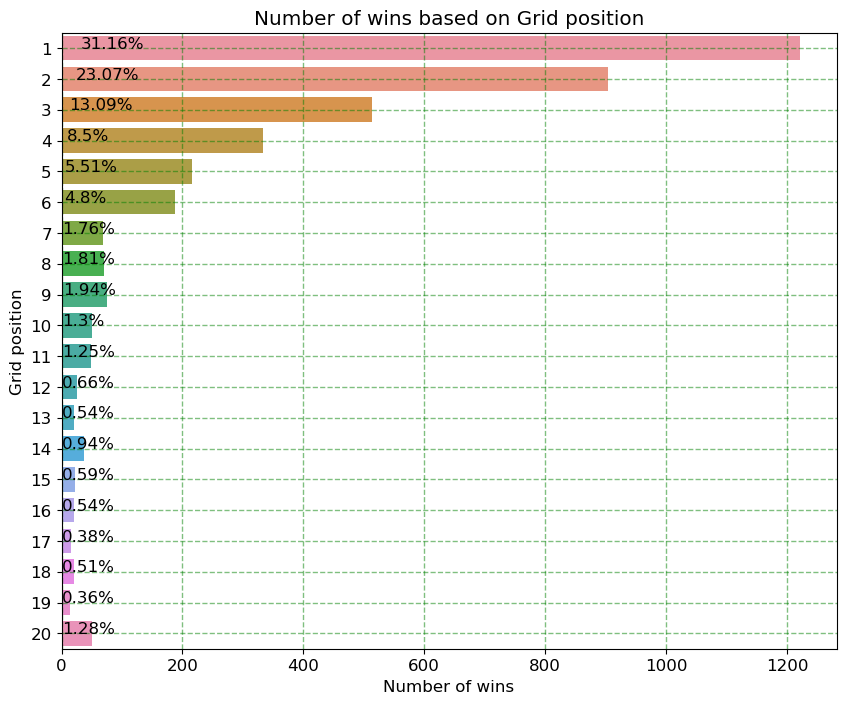

In [13]:
plt.figure(figsize=(10,8))
axes = sns.barplot( x=grid_pos['driver_wins'],y=grid_pos['grid'], orient='h')
plt.ylabel("Grid position")
plt.grid(color='g', linewidth=1, axis='both', alpha=0.5, linestyle='--') 
# setting label of x-axis
plt.xlabel("Number of wins")
plt.title("Number of wins based on Grid position")
matplotlib.rcParams.update({'font.size': 12})
for index, value in enumerate(grid_pos['Proportion']):
    plt.text(value, index,
             str(value)+'%')
plt.show()

In [14]:
correlation = grid_pos["grid"].corr(grid_pos["driver_wins"])
correlation

-0.72456685713017

## #Q6 Teams that had to retire before race completion due to car failure ##

Text(0.5, 0, 'Year')

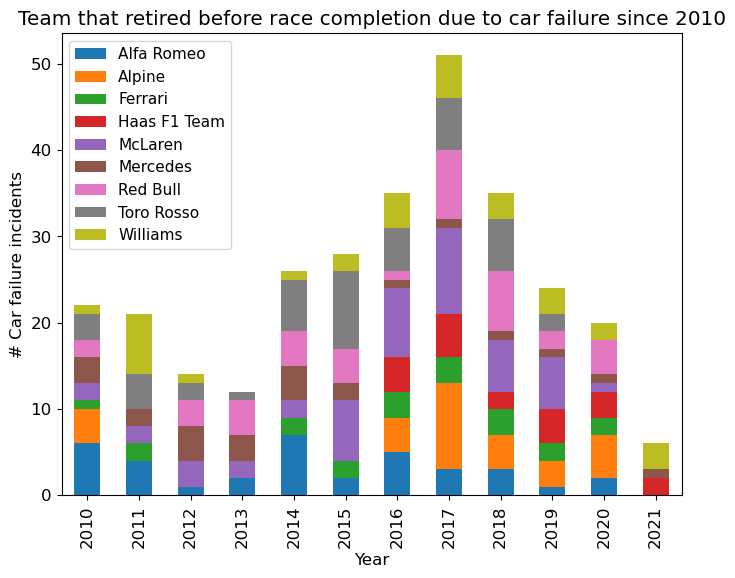

In [15]:
#results (statusId) + races (name)
team_retire = results[['raceId','statusId','constructorId']]
team_retire = pd.merge(team_retire , con_teams[['constructorId', 'name']], on='constructorId', how='left')
team_retire = pd.merge(team_retire, status[['statusId', 'status']], on='statusId', how='left')
team_retire = pd.merge(team_retire, races[['raceId','year']], on='raceId', how='left')

status_options = ['Alternator','Axle','Battery','Brake Duct','Brakes','Broken Wing','Chassis','Clutch',
                  'Crankshaft','CV joint','Damage','Electrical','Electronics','Engine','Engine fire',
                  'Engine misfire','ERS','Fuel','Fuel leak','Fuel pipe', 'Fuel pressure','Fuel pump', 
                  'Fuel rig','Fuel system','Gearbox','Oil leak','Oil line','Oil pipe','Oil pressure',
                 'Oil pump','Overheating','Pneumatics','Power loss','Power Unit','Radiator','Rear wing',
                 'Spark plugs','Steering','Supercharger','Suspension','Technical','Throttle','Transmission',
                 'Water leak','Water pipe','Water pressure','Water pump','Wheel','Wheel bearing','Wheel nut',
                 'Wheel rim']
retire = team_retire[team_retire['status'].isin(status_options)].reset_index(drop=True)
retire['name'] = np.where((retire.name == 'Sauber'),'Alfa Romeo',retire.name)
retire['name'] = np.where((retire.name == 'Renault'),'Alpine',retire.name)

retire_count = pd.DataFrame(retire.groupby(['name','year']).size().reset_index())
retire_count = retire_count.rename(columns={0:'count'})
retire_count = retire_count[retire_count['year']>=2010].reset_index(drop=True)

retire_count.groupby(['name'])['count'].sum().reset_index().sort_values(by='count', ascending = False)
#top 9 teams with car failures: Mclaren, Toro Rosso, Red Bull, Sauber(Alfa Romeo), Williams,'Renault(Alpine),
#Mercedes, Haas, Ferrari

retire_team_options = ['Mercedes','Ferrari', 'Red Bull', 'McLaren','Toro Rosso','Alfa Romeo','Williams',
                      'Alpine','Haas F1 Team']
retire_team_cf = retire_count[retire_count['name'].isin(retire_team_options)].reset_index(drop=True)
y_retire_team_cf = pd.DataFrame(retire_team_cf.groupby(['name','year'])['count'].sum()).reset_index()
y_retire_team_cf = pd.pivot_table(y_retire_team_cf, values='count', index='year', columns='name')
yy_retire_team_cf= y_retire_team_cf.reset_index()
yy_retire_team_cf = yy_retire_team_cf.fillna(0)
yy_retire_team_cf

yy_retire_team_cf.plot.bar(figsize=(8,6),stacked=True, x='year')
plt.legend(prop={"size":11})
plt.title('Team that retired before race completion due to car failure since 2010')
plt.ylabel("# Car failure incidents")
plt.xlabel("Year")

## #Q7 Does age play any role in winning the race(s)? ##

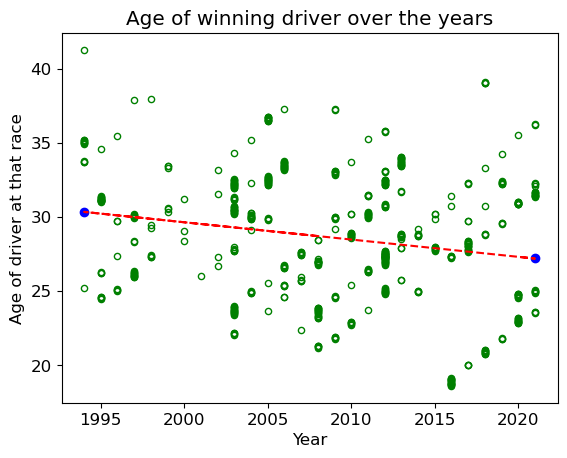

In [16]:
age_race= a1[a1['driver_wins']==1]
age_race = age_race[['year','driver_age_at_this_race']]
age_race.plot.scatter(x='year',
                     y='driver_age_at_this_race',
                     color='none',
                     edgecolor='g')
x=age_race['year']
y=age_race['driver_age_at_this_race']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")
#sorted(zip(x,p(x)))
plt.scatter(1994,30.35, c='b')
plt.scatter(2021,27.21, c='b')
plt.title('Age of winning driver over the years')
plt.ylabel("Age of driver at that race")
plt.xlabel("Year")
plt.show()

# Model building #

In [17]:
#splitting data into training and testing set
a1_train = a1.loc[(a1['year']!= 2021)] #train and validate - data prior to year 2021
a1_test = a1.loc[(a1['year']==2021)] #test - data from year 2021

#y is resultsdf_position
a1_train_x = a1_train.drop('resultsdf_position', axis=1)
a1_train_y = a1_train['resultsdf_position']

a1_test_x = a1_test.drop('resultsdf_position', axis=1)
a1_test_x = a1_test_x.reset_index(drop=True) #reseting index
a1_test_y = a1_test['resultsdf_position']

#scaling date
#a1_train_x[['actual_podium_position','grid', 'driver_points', 'driver_wins', 'con_points', 'con_s_position', 'con_wins','qualifying_position']] = minmax_scale(a1_train_x[['actual_podium_position','grid', 'driver_points', 'driver_wins', 'con_points', 'con_s_position', 'con_wins','qualifying_position']])
#a1_test_x[['actual_podium_position','grid', 'driver_points', 'driver_wins', 'con_points', 'con_s_position', 'con_wins','qualifying_position']] = minmax_scale(a1_test_x[['actual_podium_position','grid', 'driver_points', 'driver_wins', 'con_points', 'con_s_position', 'con_wins','qualifying_position']])

#converting data type to int
a1_train_y=a1_train_y.astype('int')
a1_test_y=a1_test_y.astype('int')

In [18]:
a1_train_x.columns

Index(['raceId', 'driverId', 'actual_podium_position', 'constructorId', 'grid',
       'year', 'circuitId', 'driver_age_at_this_race', 'driver_points',
       'driver_wins', 'con_points', 'con_s_position', 'con_wins',
       'qualifying_position', 'qualifying_time'],
      dtype='object')

In [19]:
# param_range = np.arange(.05, 1, 0.05)
# train_scores, test_scores = validation_curve(svm.LinearSVC(),
#                                                  X=a1_train_x,
#                                                  y=a1_train_y,
#                                                  param_name='C',
#                                                  param_range=param_range,
#                                                  cv=3,
#                                                  n_jobs=-1)
# train_mean=np.mean(train_scores, axis=1)
# train_std = np.std(train_scores,axis=1)

# test_mean = np.mean(test_scores,axis=1)
# test_std = np.std(test_scores, axis=1)
# plt.plot(param_range, train_mean, label="Training score", color='black')
# plt.plot(param_range, test_mean, label='Cross validation score', color='blue')

# plt.title("Validation curve with linear SVC")
# plt.xlabel("Values of Hyperparameter C")
# plt.ylabel("Accuracy Score")
# plt.tight_layout()
# plt.legend(loc='best')
# plt.show()

In [20]:
# param_range = np.arange(.05, 1, 0.05)
# nl_train_scores, nl_test_scores = validation_curve(svm.SVC(),
#                                                  X=a1_train_x,
#                                                  y=a1_train_y,
#                                                  param_name='C',
#                                                  param_range=param_range,
#                                                  cv=3,
#                                                  n_jobs=-1)

# nl_train_mean=np.mean(nl_train_scores, axis=1)
# nl_train_std = np.std(nl_train_scores,axis=1)

# nl_test_mean = np.mean(nl_test_scores,axis=1)
# nl_test_std = np.std(nl_test_scores, axis=1)
# #plt.plot(param_range, nl_train_mean, label="Training score", color='black')
# plt.plot(param_range, nl_test_mean, label='Cross validation score', color='blue')

# plt.title("Validation curve with non-linear SVC")
# plt.xlabel("Values of Hyperparameter C")
# plt.ylabel("Accuracy Score")
# plt.tight_layout()
# plt.legend(loc='best')
# plt.show()

In [21]:
# clf=svm.SVC(gamma=0.001, C=100.)
# model=clf.fit(a1_train_x,a1_train_y)
# SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
#    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
#     max_iter=-1, probability=False, random_state=None, shrinking=True,
#    tol=0.001, verbose=False)
# print(model.score(a1_test_x, a1_test_y))



In [22]:
# model.predict(a1_test_x)

In [23]:
# a1_test_y

## Classification Models ##

### SVC ###

In [24]:
a1_svm = svm.SVC(gamma = 0.00001,kernel='linear', probability = True) #kernel='linear'
a1_svm.fit(a1_train_x, a1_train_y) # We use an SVC with an RBF kernel

#predicting probabilities and reseting index
a1_svm_prediction_df = pd.DataFrame(a1_svm.predict_proba(a1_test_x), columns= ['proba_0', 'proba_1'])
a1_svm_prediction_df['actual'] = a1_test_y.reset_index(drop=True)

#merging to get reference data for comparison
a1_svm_predict_results = a1_svm_prediction_df.join(a1_test_x)

a1_svm_predict_results = pd.merge(a1_svm_predict_results, drivers[['driverId', 'driverRef']], on='driverId', how='left')
a1_svm_predict_results = pd.merge(a1_svm_predict_results, races[['raceId', 'name']], on='raceId', how='left')
a1_svm_predict_results = pd.merge(a1_svm_predict_results, circuits[['circuitId','location','country']], on='circuitId', how='left')

#final results for SVC model
a1_svm_results = a1_svm_predict_results[['driverRef','year', 'name','location','country','raceId', 'proba_1','actual','actual_podium_position']]
a1_svm_results = a1_svm_results.sort_values(by=['raceId'])


In [25]:
a1_svm_results['predict'] = a1_svm_results.groupby(['raceId'])['proba_1'].transform('max')
a1_svm_results['SVM_prediction'] = np.where((a1_svm_results['proba_1']==a1_svm_results['predict']), 1, 0)

In [26]:
#prediction score for SVC model
svc_p_score = precision_score(a1_svm_results.actual, a1_svm_results.SVM_prediction)
svc_p_score

0.625

In [27]:
print('Confusion matrix and Classification report for SVM model')
print(confusion_matrix(a1_svm_results.actual, a1_svm_results.SVM_prediction))
print(classification_report(a1_svm_results.actual, a1_svm_results.SVM_prediction))

Confusion matrix and Classification report for SVM model
[[297   6]
 [  6  10]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       303
           1       0.62      0.62      0.62        16

    accuracy                           0.96       319
   macro avg       0.80      0.80      0.80       319
weighted avg       0.96      0.96      0.96       319



### Neural network  ###

In [28]:
#fitting model (Classification)
#scaling date
#a1_train_x[['actual_podium_position','grid', 'driver_points', 'driver_wins', 'con_points', 'con_s_position', 'con_wins','qualifying_position']] = minmax_scale(a1_train_x[['actual_podium_position','grid', 'driver_points', 'driver_wins', 'con_points', 'con_s_position', 'con_wins','qualifying_position']])
#a1_test_x[['actual_podium_position','grid', 'driver_points', 'driver_wins', 'con_points', 'con_s_position', 'con_wins','qualifying_position']] = minmax_scale(a1_test_x[['actual_podium_position','grid', 'driver_points', 'driver_wins', 'con_points', 'con_s_position', 'con_wins','qualifying_position']])

a1_nn = MLPClassifier(hidden_layer_sizes = (40,40,40), activation = 'tanh', solver = 'lbfgs', alpha=1e-5,max_iter=500, random_state=1)
a1_nn.fit(a1_train_x, a1_train_y) # We use Neural network

#predicting probabilities and reseting index
a1_nn_prediction_df = pd.DataFrame(a1_nn.predict_proba(a1_test_x), columns= ['proba_0', 'proba_1'])
a1_nn_prediction_df['actual'] = a1_test_y.reset_index(drop=True)

#merging to get reference data for comparison
a1_nn_predict_results = a1_nn_prediction_df.join(a1_test_x)

a1_nn_predict_results = pd.merge(a1_nn_predict_results, drivers[['driverId', 'driverRef']], on='driverId', how='left')
a1_nn_predict_results = pd.merge(a1_nn_predict_results, races[['raceId', 'name']], on='raceId', how='left')
#a1_nn_predict_results = pd.merge(a1_nn_predict_results, circuits[['location','country','circuitId']], on='circuitId', how='left')

#final results for NN model
a1_nn_results = a1_nn_predict_results[['driverRef','year', 'name','raceId', 'proba_1','actual','actual_podium_position']]
a1_nn_results = a1_nn_results.sort_values(by=['raceId'])



/Users/Niki/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [29]:
a1_nn_results['predict'] = a1_nn_results.groupby(['raceId'])['proba_1'].transform('max')
a1_nn_results['NN_prediction'] = np.where((a1_nn_results['proba_1']==a1_nn_results['predict']), 1, 0)

In [30]:
#prediction score for NN model
nn_p_score = precision_score(a1_nn_results.actual, a1_nn_results.NN_prediction)
nn_p_score

0.4375

In [31]:
print('Confusion matrix and Classification report for Neural network model')
print(confusion_matrix(a1_nn_results.actual, a1_nn_results.NN_prediction))
print(classification_report(a1_nn_results.actual, a1_nn_results.NN_prediction))

Confusion matrix and Classification report for Neural network model
[[294   9]
 [  9   7]]
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       303
           1       0.44      0.44      0.44        16

    accuracy                           0.94       319
   macro avg       0.70      0.70      0.70       319
weighted avg       0.94      0.94      0.94       319



## Regression Models ##

### Linear Regression ###

In [32]:
#scaling date
a1_train_x[['actual_podium_position','grid', 'driver_points', 'driver_wins', 'con_points', 'con_s_position', 'con_wins','qualifying_position']] = minmax_scale(a1_train_x[['actual_podium_position','grid', 'driver_points', 'driver_wins', 'con_points', 'con_s_position', 'con_wins','qualifying_position']])
a1_test_x[['actual_podium_position','grid', 'driver_points', 'driver_wins', 'con_points', 'con_s_position', 'con_wins','qualifying_position']] = minmax_scale(a1_test_x[['actual_podium_position','grid', 'driver_points', 'driver_wins', 'con_points', 'con_s_position', 'con_wins','qualifying_position']])
a1_linr = LinearRegression(fit_intercept=True)
a1_linr.fit(a1_train_x, a1_train_y) # We use linear regression

#predicting probabilities and reseting index
a1_linr_prediction_df = pd.DataFrame(a1_linr.predict(a1_test_x), columns= ['predict'])
a1_linr_prediction_df['actual'] = a1_test_y.reset_index(drop=True)

#merging to get reference data for comparison
a1_linr_predict_results = a1_linr_prediction_df.join(a1_test_x)

a1_linr_predict_results = pd.merge(a1_linr_predict_results, drivers[['driverId', 'driverRef']], on='driverId', how='left')
a1_linr_predict_results = pd.merge(a1_linr_predict_results, races[['raceId', 'name']], on='raceId', how='left')
a1_linr_predict_results = pd.merge(a1_linr_predict_results, circuits[['circuitId','location','country']], on='circuitId', how='left')

#final results for Linear Regression model
a1_linr_results = a1_linr_predict_results[['driverRef','year', 'name','location','country','raceId', 'predict','actual','actual_podium_position']]
a1_linr_results = a1_linr_results.sort_values(by=['raceId'])

In [33]:
a1_linr_results['pred'] = a1_linr_results.groupby(['raceId'])['predict'].transform('max')
a1_linr_results['LR_prediction'] = np.where((a1_linr_results['pred']==a1_linr_results['predict']), 1, 0)
a1_linr_results = a1_linr_results.drop('pred', axis=1)

In [34]:
print('Confusion matrix and Classification report for Linear regression model')
print(confusion_matrix(a1_linr_results.actual, a1_linr_results.LR_prediction))
print(classification_report(a1_linr_results.actual, a1_linr_results.LR_prediction))

Confusion matrix and Classification report for Linear regression model
[[294   9]
 [  9   7]]
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       303
           1       0.44      0.44      0.44        16

    accuracy                           0.94       319
   macro avg       0.70      0.70      0.70       319
weighted avg       0.94      0.94      0.94       319



In [35]:
pd.set_option('display.max_rows', None)
#a1_linr_results

#prediction score for Linear Regression model
linr_p_score = precision_score(a1_linr_results.actual, a1_linr_results.LR_prediction)
linr_p_score

0.4375

### Random Forest ###

In [36]:
#scaling date
#a1_train_x[['actual_podium_position','grid', 'driver_points', 'driver_wins', 'con_points', 'con_s_position', 'con_wins','qualifying_position']] = minmax_scale(a1_train_x[['actual_podium_position','grid', 'driver_points', 'driver_wins', 'con_points', 'con_s_position', 'con_wins','qualifying_position']])
#a1_test_x[['actual_podium_position','grid', 'driver_points', 'driver_wins', 'con_points', 'con_s_position', 'con_wins','qualifying_position']] = minmax_scale(a1_test_x[['actual_podium_position','grid', 'driver_points', 'driver_wins', 'con_points', 'con_s_position', 'con_wins','qualifying_position']])
a1_rfr = RandomForestRegressor(criterion ='squared_error', max_features=10, random_state=23) #replaced mse with squared_error
a1_rfr.fit(a1_train_x, a1_train_y) # We use Random Forest regression

#predicting probabilities and reseting index
a1_rfr_prediction_df = pd.DataFrame(a1_rfr.predict(a1_test_x), columns= ['predict'])
a1_rfr_prediction_df['actual'] = a1_test_y.reset_index(drop=True)

#merging to get reference data for comparison
a1_rfr_predict_results = a1_rfr_prediction_df.join(a1_test_x)

a1_rfr_predict_results = pd.merge(a1_rfr_predict_results, drivers[['driverId', 'driverRef']], on='driverId', how='left')
a1_rfr_predict_results = pd.merge(a1_rfr_predict_results, races[['raceId', 'name']], on='raceId', how='left')
a1_rfr_predict_results = pd.merge(a1_rfr_predict_results, circuits[['location','country','circuitId']], on='circuitId', how='left')


#final results for Linear Regression model
a1_rfr_results = a1_rfr_predict_results[['driverRef','year', 'name','raceId','country','location','predict','actual','actual_podium_position']]
a1_rfr_results = a1_rfr_results.sort_values(by=['raceId'])

a1_rfr_results['pred'] = a1_rfr_results.groupby(['raceId'])['predict'].transform('max')
a1_rfr_results['RF_prediction'] = np.where((a1_rfr_results['pred']==a1_rfr_results['predict']), 1, 0)
a1_rfr_results = a1_rfr_results.drop('pred', axis=1)


#prediction score for Linear Regression model
rfr_p_score = precision_score(a1_rfr_results.actual, a1_rfr_results.RF_prediction)
rfr_p_score

0.75

In [37]:
print('Confusion matrix and Classification report for Random Forest regression model')
print(confusion_matrix(a1_rfr_results.actual, a1_rfr_results.RF_prediction))
print(classification_report(a1_rfr_results.actual, a1_rfr_results.RF_prediction))

Confusion matrix and Classification report for Random Forest regression model
[[299   4]
 [  4  12]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       303
           1       0.75      0.75      0.75        16

    accuracy                           0.97       319
   macro avg       0.87      0.87      0.87       319
weighted avg       0.97      0.97      0.97       319



In [38]:
a1_rfr_results['pred'] = a1_rfr_results.groupby(['raceId'])['predict'].transform('max')
a1_rfr_results['RF_prediction'] = np.where((a1_rfr_results['pred']==a1_rfr_results['predict']), 1, 0)
a1_rfr_results = a1_rfr_results.drop('pred', axis=1)

In [39]:
print(svc_p_score, nn_p_score, linr_p_score)


0.625 0.4375 0.4375


In [40]:
pscore_df = pd.DataFrame([['SVM classification',svc_p_score],['Neural Network classification',nn_p_score],['Linear Regression',linr_p_score],
                         ['Random Forest Regression',rfr_p_score]], 
                         columns=['Model','Precision Score'])
pscore_df

,Model,Precision Score
0,SVM classification,0.6250
1,Neural Network classification,0.4375
2,Linear Regression,0.4375
3,Random Forest Regression,0.7500


(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]),
 [Text(0.0, 0, '0.0'),
  Text(0.1, 0, '0.1'),
  Text(0.2, 0, '0.2'),
  Text(0.30000000000000004, 0, '0.3'),
  Text(0.4, 0, '0.4'),
  Text(0.5, 0, '0.5'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.7000000000000001, 0, '0.7'),
  Text(0.8, 0, '0.8')])

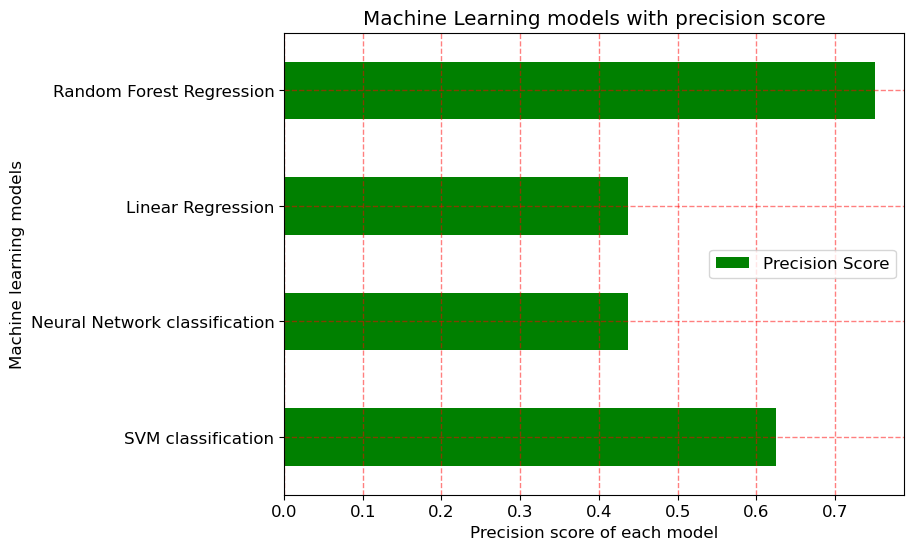

In [41]:
pscore_df.plot.barh(figsize=(8,6),stacked=True, x='Model', color='g')
plt.grid(color='r', linewidth=1, axis='both', alpha=0.5, linestyle='--')
plt.title('Machine Learning models with precision score')
plt.xlabel("Precision score of each model")
plt.ylabel("Machine learning models")
plt.xticks(wrap=True)

In [42]:
a1_svm_results = a1_svm_results.reset_index(drop=False)
a1_nn_results = a1_nn_results.reset_index(drop=False)
a1_linr_results = a1_linr_results.reset_index(drop=False)
a1_rfr_results = a1_rfr_results.reset_index(drop=False)

In [43]:
a1_rfr_results.head()

,index,driverRef,year,name,raceId,country,location,predict,actual,actual_podium_position,RF_prediction
0,0,hamilton,2021,Bahrain Grand Prix,1052,Bahrain,Sakhir,0.53,1,0.00,1
1,256,russell,2021,Bahrain Grand Prix,1052,Bahrain,Sakhir,0.00,0,0.65,0
2,32,alonso,2021,Bahrain Grand Prix,1052,Bahrain,Sakhir,0.00,0,0.90,0
3,33,ocon,2021,Bahrain Grand Prix,1052,Bahrain,Sakhir,0.00,0,0.60,0
4,225,tsunoda,2021,Bahrain Grand Prix,1052,Bahrain,Sakhir,0.00,0,0.40,0


In [44]:
a1_rfr_results[['driverRef','year','name','actual','predict','RF_prediction']].head()

,driverRef,year,name,actual,predict,RF_prediction
0,hamilton,2021,Bahrain Grand Prix,1,0.53,1
1,russell,2021,Bahrain Grand Prix,0,0.00,0
2,alonso,2021,Bahrain Grand Prix,0,0.00,0
3,ocon,2021,Bahrain Grand Prix,0,0.00,0
4,tsunoda,2021,Bahrain Grand Prix,0,0.00,0


In [45]:
final_model_rs = pd.merge(a1_svm_results[['driverRef','year','name','actual','index','SVM_prediction']],a1_nn_results[['index','NN_prediction']], 
                          on='index',how='left')
final_model_rs = pd.merge(final_model_rs,a1_linr_results[['index','LR_prediction']], 
                          on='index',how='left')
final_model_rs = pd.merge(final_model_rs,a1_rfr_results[['index','RF_prediction']], 
                          on='index',how='left')
final_model_rs = final_model_rs[final_model_rs['actual']==1]

In [46]:
pd.set_option('display.max_rows', 17)
final_model_rs = final_model_rs.drop(columns=['index'])

In [47]:
final_model_rs.reset_index(drop=True)

,driverRef,year,name,actual,SVM_prediction,NN_prediction,LR_prediction,RF_prediction
0,hamilton,2021,Bahrain Grand Prix,1,1,1,1,1
1,max_verstappen,2021,Emilia Romagna Grand Prix,1,0,0,0,0
2,hamilton,2021,Portuguese Grand Prix,1,1,1,1,1
3,hamilton,2021,Spanish Grand Prix,1,1,1,1,1
4,max_verstappen,2021,Monaco Grand Prix,1,1,1,0,1
5,perez,2021,Azerbaijan Grand Prix,1,0,0,0,0
6,max_verstappen,2021,Styrian Grand Prix,1,1,0,1,1
7,max_verstappen,2021,French Grand Prix,1,1,0,0,1
8,max_verstappen,2021,Austrian Grand Prix,1,1,1,1,1
9,hamilton,2021,British Grand Prix,1,0,1,0,0


In [48]:
a1['year'].unique().max()

2021